# MS-HLAM: multi-service hierarchical location-allocation model <br> 10 DECEMBER 2024

In [24]:
"""
Note: I need to import the data from parameters.py
"""

'\nNote: I need to import the data from the Data_Dec24.ipynb file and parameters.py\n'

In [77]:
import geopandas as gpd
import numpy as np
import pandas as pd
import itertools
from parameters import dps, hfs, hps, hcs, services, health_workers, levels, HFs_to_locate, dd_oh, dd_ch, distance_matrix, workers_to_allocate, lb_workers, a_HF, a_W, t1max, service_time, working_hours, get_nearby_HFs
import pyomo.environ as pyo

from parameters import location_nodes, demand_points_gdf, hfs_gdf, hps_gdf, hcs_gdf
import matplotlib.pyplot as plt


In [5]:
# Define the sets and parameters
I = dps
J = hfs
J_HP = hps
J_HC = hcs
t = distance_matrix # travel time (distances)  between demand points and HFs
J_i = get_nearby_HFs(distance_matrix, dps, t1max)
S = services
P = health_workers
L = levels
n_HF = dict(zip(levels, HFs_to_locate))
n_W = dict(zip(health_workers, workers_to_allocate))
d1 = dd_oh
d2 = dd_ch
lb = lb_workers
q = dict(zip(services, service_time))
c = dict(zip(health_workers, working_hours))


In [395]:
def model_mshlam_dec24(I, J, J_HP, J_HC, S, P, L, n_HF, d1, d2, t, n_W, lb, a_HF, a_W, t1max, J_i, q, c):
    """
    Inputs:
    
        I (array): (indices of) demand points; eg, ['i1',...,'i16']
        J (array): (indices of) candidate locations for HFs; eg, ['j1',...,'j9']
        J_HP (array): (indices of) candidate locations for HPs; eg, ['j2','j3','j4','j6','j7','j8']
        J_HC (array): (indices of) candidate locations for HCs; eg, ['j1','j3','j4','j5','j9']
        S (array): (indices of) types of services; eg, ['basic','maternal1','maternal2']
        P (array): (indices of) types of health workers; eg, ['doctor','nurse','midwife']
        L (array): (indices of) levels of HFs; eg, ['hp','hc']
    
        n_HF (dict): per l in L, the number of HF of level l to locate
        d1 (dict): per i in I and s in S, the number of people from i demanding service s during HP's opening times
        d2 (dict): per i in I and s in S, the number of people from i demanding service s outside of HP's opening times
        t (DataFrame): travel times (distances) between pairs of location nodes, ie, between pairs in {I, J_HP, J_JC}   
        n_W (dict): per p in P, the number of health workers of type p to locate
        lb (dict): per p in P and l in L, the minimum number of health workers of type p that need to be present at an open HF of level l
        a_HF (dict): per s in S and l in L, boolean operator indicating whether service s can be provided at a HF of level l (1) or not (0)
        a_W (dict): per p in P and s in S, boolean operator indicating whether health worker type p is able to deliver service s (1) or not (0)
        t1max (integer): maximum/coverage travel time (distance) from a demand point to the HF that is its first assignment
        J_i (dictionary of arrays): per i in I, the list of j in J = {J_HP, J_HC} that are reachable within t1max
        q (dict): per s in S, the service time for s
        c (dict): per p in P, the number of daily working hours for health worker of type p
        
        
    
    Returns: m
        
    """

    
    m = pyo.ConcreteModel('MSHLAM')
    
    # Function to remove all components from the model
    def remove_all_components(m):
        components = list(m.component_objects())
        for comp in components:
            m.del_component(comp)
    
    # Remove all components from the model
    remove_all_components(m)
    
    m.I = pyo.Set(initialize=I)
    m.J = pyo.Set(initialize=J)
    m.J_HP = pyo.Set(initialize=J_HP)
    m.J_HC = pyo.Set(initialize=J_HC)
        
    @m.Param(m.I, within=pyo.Any)
    def JI(m, i):
       return J_i.get(i,[])    
    
    m.S = pyo.Set(initialize=S)
    m.P = pyo.Set(initialize=P)
    m.L = pyo.Set(initialize=L)
    
    m.n_HF = pyo.Param(m.L, initialize=n_HF, within=pyo.Integers)
    m.d1 = pyo.Param(m.I, m.S, initialize=d1, within=pyo.NonNegativeReals)
    m.d2 = pyo.Param(m.I, m.S, initialize=d2, within=pyo.NonNegativeReals)
    
    m.t = pyo.Param(m.I, m.J, initialize={(i, j): t.loc[i, j] for i in t.index for j in t.columns})
    
    m.n_W = pyo.Param(m.P, initialize=n_W, within=pyo.Integers)
    m.lb = pyo.Param(m.P, m.L, initialize=lb, within=pyo.Integers)
    m.a_HF = pyo.Param(m.S, m.L, initialize=a_HF, within=pyo.Binary)
    m.a_W = pyo.Param(m.P, m.S, initialize=a_W, within=pyo.Binary)
    
    m.t1max = pyo.Param(initialize=t1max, within=pyo.NonNegativeReals) #Not sure if I need to do this, as it is just a constant
    
    m.q = pyo.Param(m.S, initialize=q, within=pyo.NonNegativeReals)
    m.c = pyo.Param(m.P, initialize=c, within=pyo.NonNegativeReals)
    
    # Variables:
    m.y = pyo.Var(m.J, m.L, within=pyo.Binary)
    m.x1 = pyo.Var(m.I, m.J, m.S, within=pyo.Binary)
    m.x2 = pyo.Var(m.I, m.J_HC, m.S, within=pyo.Binary)
    m.f1 = pyo.Var(m.I, m.J, m.S, within=pyo.NonNegativeIntegers)
    m.f2 = pyo.Var(m.I, m.J_HC, m.S, within=pyo.NonNegativeIntegers)
    m.z = pyo.Var(m.J, m.S, within=pyo.Binary)
    m.w = pyo.Var(m.J, m.P, m.S, within=pyo.NonNegativeIntegers)
    m.t2max = pyo.Var(within=pyo.NonNegativeReals)
    m.delta = pyo.Var(m.J, m.S, within=pyo.NonNegativeIntegers)
    m.deltamax = pyo.Var(within=pyo.NonNegativeIntegers)
    
    
    # OBJECTIVES
    @m.Objective(sense=pyo.maximize)
    def O1_people_covered(m):
        return pyo.quicksum(m.f1[i,j,s] for i in m.I for j in m.J for s in m.S)
    
    
    @m.Objective(sense=pyo.minimize)
    def O2_travel_time_second_assignment(m):
        return m.t2max
    
    
    @m.Objective(sense=pyo.minimize)
    def O3_unmet_demand(m):
        return m.deltamax
    
    
    # Combine the objectives into a single objective function
    @m.Objective(sense=pyo.maximize)
    def Combined_Objective(m):
        return 0.5 * m.O1_people_covered.expr - 0.5 * m.O2_travel_time_second_assignment.expr - 0 * m.O3_unmet_demand.expr
    
    
    # CONSTRAINTS
    @m.Constraint(m.L)
    def R1_budget_HFs(m, l):
        return pyo.quicksum(m.y[j,l] for j in m.J) <= m.n_HF[l]
    
    
    @m.Constraint(m.J, m.L)
    def R2_location_HFs(m, j, l):
        if (j not in m.J_HP and l == 'hp') or (j not in m.J_HC and l == 'hc'):
            return m.y[j, l] == 0
        return pyo.Constraint.Skip
    
    
    @m.Constraint(m.J)
    def R3_one_HF_per_location(m, j):
        return pyo.quicksum(m.y[j,l] for l in m.L) <= 1
        
    
    @m.Constraint(m.I, m.S)
    def R4_first_assignment(m, i, s):
        return pyo.quicksum(m.x1[i,j,s] for j in m.JI[i]) <=  1 

       
    @m.Constraint(m.I, m.J, m.S)
    def R5_first_assignment_only_within_reach(m, i, j, s):
        if (j not in m.JI[i]):
            return m.x1[i,j,s] ==  0 
        return pyo.Constraint.Skip
    
    
    @m.Constraint(m.I, m.J, m.S, m.S)
    def R6_same_first_assignment(m, i, j, s, ss):
        if s != ss:  # Ensure that s and ss are different (otherwise, redundant)
            return m.x1[i, j, s] - m.x1[i, j, ss] == 0
        return pyo.Constraint.Skip
    
    
    
    @m.Constraint(m.I, m.S)
    def R7_second_assignment(m, i, s):
        return pyo.quicksum(m.x2[i,j,s] for j in m.J_HC) ==  1 
    
    
    @m.Constraint(m.I, m.J_HC, m.S, m.S)
    def R8_same_second_assignment(m, i, j, s, ss):
        if s != ss:  # Ensure that s and ss are different (otherwise, redundant)
            return m.x2[i, j, s] - m.x2[i, j, ss] == 0
        return pyo.Constraint.Skip
    
    
    @m.Constraint(m.I, m.J_HC, m.S)
    def R9_first_assignment_is_HC(m, i, j, s):
        return 1 - m.x2[i, j, s] <= (1 - m.y[j, 'hc']) + (1 - m.x1[i, j, s])
    
    
    @m.Constraint(m.I, m.J_HC, m.S)
    def R10_maximum_distance_second_assignment(m, i, j, s):
        return m.t2max >= m.t[i, j] * m.x2[i, j, s] 
    
    
    @m.Constraint(m.I, m.J, m.S)
    def R11_first_allocation_must_exist(m, i, j, s):
        return m.x1[i,j,s] <= pyo.quicksum(m.y[j,l] for l in m.L)
    
    
    @m.Constraint(m.I, m.J_HC, m.S)
    def R12_second_allocation_must_exist(m, i, j, s):
        return m.x2[i,j,s] <= m.y[j,'hc']
    
    
    @m.Constraint(m.J, m.L)
    def R13_people_must_be_allocated_first_assignment(m, j, l):
        return m.y[j,l] <= pyo.quicksum(m.x1[i,j,s] for i in m.I for s in m.S)
    
    
    @m.Constraint(m.J_HC)
    def R14_people_must_be_allocated_second_assignment(m, j):
        return m.y[j,'hc'] <= pyo.quicksum(m.x2[i,j,s] for i in m.I for s in m.S)
    
    
    @m.Constraint(m.I, m.J, m.S)
    def R15_relation_flow_first_assignment(m, i, j, s):
        return m.f1[i,j,s] == m.d1[i,s]*m.x1[i,j,s]
    
    
    @m.Constraint(m.I, m.J_HC, m.S)
    def R16_relation_flow_second_assignment(m, i, j, s):
        return m.f2[i,j,s] == m.d2[i,s]*m.x2[i,j,s]
    
    """
    @m.Constraint(m.J_HP, m.S)
    def R17_unmet_demand_HPs(m, j, s):
        return pyo.quicksum(m.f1[i,j,s] for i in m.I) <= (1/m.q[s])*pyo.quicksum(m.c[p]*m.a_W[p,s]*m.w[j,p,s] for p in m.P) + m.delta[j,s]
    
    
    @m.Constraint(m.J_HC, m.S)
    def R18_unmet_demand_HCs(m, j, s):
        return pyo.quicksum((m.f1[i,j,s] + m.f2[i,j,s]) for i in m.I) <= (1/m.q[s])*pyo.quicksum(m.c[p]*m.a_W[p,s]*m.w[j,p,s] for p in m.P) + m.delta[j,s]
    
    
    @m.Constraint(m.J)
    def R19_max_unmet_demand(m, j):
        return m.deltamax >= pyo.quicksum(m.delta[j,s] for s in m.S)
    """

    
    @m.Constraint(m.J, m.S)
    def R20_no_located_HF_no_services(m, j, s):
        return m.z[j,s] <= pyo.quicksum(m.a_HF[s,l]*m.y[j,l] for l in m.L)
    
    
    @m.Constraint(m.J, m.L)
    def R21_no_services_no_located_HF(m, j, l):
        return m.y[j,l] <= pyo.quicksum(m.z[j,s] for s in m.S)
    
    
    @m.Constraint(m.J, m.S)
    def R22_no_services_no_allocated_patients_first_assignment(m, j, s):
        return pyo.quicksum(m.x1[i,j,s] for i in m.I) <= len(m.I)*m.z[j,s]
    
    
    @m.Constraint(m.J_HC, m.S)
    def R23_no_services_no_allocated_patients_second_assignment(m, j, s):
        return pyo.quicksum(m.x2[i,j,s] for i in m.I) <= len(m.I)*m.z[j,s]
    
    """
    @m.Constraint(m.P)
    def R24_allocation_workers(m, p):
        return pyo.quicksum(m.w[j,p,s] for j in m.J for s in m.S) == m.n_W[p]
    
    
    @m.Constraint(m.J, m.P, m.S)
    def R25_no_service_no_worker(m, j, p, s):
        return m.w[j,p,s] <= m.n_W[p]*m.a_W[p,s]*m.z[j,s]
    
    
    @m.Constraint(m.J, m.P, m.S, m.L)
    def R26_lower_bounds_workers(m, j, p, s, l):
        return m.lb[p,l]*m.z[j,s] <= m.w[j,p,s]
    
    """
    return m


In [ ]:
    @m.Constraint(m.I, m.J, m.S, m.S, m.L)
    def R6_2_prueba_11DEC(m, i, j, s, ss, l):
        if s != ss:  # Ensure that s and ss are different (otherwise, redundant)
            return m.x1[i, j, s] - m.x1[i, j, ss] <= (1 - m.y[j,l]) + (m.z[j,s] - m.z[j,ss])
        return pyo.Constraint.Skip
    

In [397]:
model = model_mshlam_dec24(I, J, J_HP, J_HC, S, P, L, n_HF, d1, d2, t, n_W, lb, a_HF, a_W, t1max, J_i, q, c)
# model.pprint() # to display the entire model
# model.display() # 

# To save the model in a .txt for further exploration:
# with open("model_output.txt", "w") as f:
#     model.pprint(ostream=f)

# Deactive the objectives you don't want to use
#model.O1_people_covered.deactivate()
model.O2_travel_time_second_assignment.deactivate()
model.O3_unmet_demand.deactivate()
model.Combined_Objective.deactivate()
#model.R10_maximum_distance_second_assignment.deactivate()

# Activate the objective you are interested in 
#model.O1_people_covered.activate()

for obj in model.component_objects(pyo.Objective, active=True):
    print(f"Active Objective: {obj.name}")

Active Objective: O1_people_covered


In [399]:
solver = pyo.SolverFactory('cplex')
results = solver.solve(model)


In [401]:
print(results)
      


Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3605
  Number of variables: 1390
  Number of nonzeros: 9699
  Sense: unknown
Solver: 
- Status: ok
  User time: 0.02
  Termination condition: infeasible
  Termination message: MIP - Integer infeasible.
  Error rc: 0
  Time: 0.06049036979675293



In [365]:

# Display the results
#model.display()



# Display only the selected variables
print("Selected variables (y_jl = 1, x1_ijs = 1, x2_ijs = 1, f1_ijs > 0, f2_ijs > 0, z_js = 1, w_jps > 0, t2max > 0, delta_js > 0, deltamax > 0):")
for j in model.J:
        for l in model.L:
            if model.y[j, l].value is not None and model.y[j, l].value == 1:
                print(f"y[{j},{l}] = {model.y[j, l].value}")
for i in model.I:
        for j in model.J:
            for s in model.S:
                if model.x1[i, j, s].value is not None and model.x1[i, j, s].value == 1:
                    print(f"x1[{i},{j},{s}] = {model.x1[i, j, s].value}") 
for i in model.I:
        for j in model.J_HC:
            for s in model.S:
                if model.x2[i, j, s].value is not None and model.x2[i, j, s].value == 1:
                    print(f"x2[{i},{j},{s}] = {model.x2[i, j, s].value}") 
for i in model.I:
        for j in model.J:
            for s in model.S:
                if model.f1[i, j, s].value is not None and model.f1[i, j, s].value > 0:
                    print(f"f1[{i},{j},{s}] = {model.f1[i, j, s].value}") 
for i in model.I:
        for j in model.J_HC:
            for s in model.S:
                if model.f2[i, j, s].value is not None and model.f2[i, j, s].value > 0:
                    print(f"f2[{i},{j},{s}] = {model.f2[i, j, s].value}") 
for j in model.J:
    for s in model.S:
            if model.z[j,s].value is not None and model.z[j,s].value == 1:
                print(f"z[{j},{s}] = {model.z[j, s].value}")
for j in model.J:
        for p in model.P:
            for s in model.S:
                if model.w[j,p, s].value is not None and model.w[j, p, s].value > 0:
                    print(f"w[{j},{p},{s}] = {model.w[j, p, s].value}") 
if model.t2max.value is not None and model.t2max.value > 0:
    print(f"t2max = {model.t2max.value}") 
for j in model.J:
    for s in model.S:            
        if model.delta[j,s].value is not None and model.delta[j,s].value > 0:
            print(f"delta[{j},{s}] = {model.delta[j, s].value}")
if model.deltamax.value is not None and model.deltamax.value > 0:
    print(f"deltamax = {model.deltamax.value}") 
# %%

Selected variables (y_jl = 1, x1_ijs = 1, x2_ijs = 1, f1_ijs > 0, f2_ijs > 0, z_js = 1, w_jps > 0, t2max > 0, delta_js > 0, deltamax > 0):
y[j1,hc] = 1.0
y[j2,hp] = 1.0
y[j4,hp] = 1.0
y[j8,hp] = 1.0
y[j9,hc] = 1.0
x1[i1,j1,maternal2] = 1.0
x1[i1,j2,basic] = 1.0
x1[i1,j2,maternal1] = 1.0
x1[i2,j1,maternal1] = 1.0
x1[i2,j1,maternal2] = 1.0
x1[i2,j2,basic] = 1.0
x1[i3,j1,maternal1] = 1.0
x1[i3,j1,maternal2] = 1.0
x1[i3,j2,basic] = 1.0
x1[i4,j2,basic] = 1.0
x1[i4,j2,maternal1] = 1.0
x1[i5,j1,maternal2] = 1.0
x1[i5,j4,basic] = 1.0
x1[i5,j4,maternal1] = 1.0
x1[i6,j1,maternal2] = 1.0
x1[i6,j4,basic] = 1.0
x1[i6,j4,maternal1] = 1.0
x1[i7,j1,maternal2] = 1.0
x1[i7,j4,basic] = 1.0
x1[i7,j8,maternal1] = 1.0
x1[i8,j2,basic] = 1.0
x1[i8,j9,maternal1] = 1.0
x1[i8,j9,maternal2] = 1.0
x1[i9,j1,maternal2] = 1.0
x1[i9,j4,maternal1] = 1.0
x1[i9,j8,basic] = 1.0
x1[i10,j1,maternal2] = 1.0
x1[i10,j4,basic] = 1.0
x1[i10,j4,maternal1] = 1.0
x1[i11,j4,basic] = 1.0
x1[i11,j4,maternal1] = 1.0
x1[i11,j9,maternal2

In [227]:
# Extract open facilities from the model
open_facilities = {
    j: l
    for (j, l) in model.y.keys()
    if pyo.value(model.y[j, l]) > 0  # Only keep open facilities
}

In [229]:
open_facilities

{'j2': 'hp', 'j3': 'hc', 'j5': 'hc', 'j6': 'hp', 'j7': 'hp'}

In [231]:
# Open facilities GeoDataFrame
open_hfs_gdf = hfs_gdf[hfs_gdf['label'].isin(open_facilities.keys())].copy()

open_hfs_gdf

,index,type_f,id,geometry,x,y,label
1,5,HP,hp1,POINT (3 1),3.0,1.0,j2
2,9,HP,hp2,POINT (5 2),5.0,2.0,j3
4,15,HC,hc4,POINT (1 4),1.0,4.0,j5
5,18,HP,hp4,POINT (5 4),5.0,4.0,j6
6,20,HP,hp5,POINT (1 5),1.0,5.0,j7


In [233]:

# Add a column for facility type (HP or HC) based on l
open_hfs_gdf['facility_type'] = open_hfs_gdf['label'].map(open_facilities)
open_hfs_gdf

,index,type_f,id,geometry,x,y,label,facility_type
1,5,HP,hp1,POINT (3 1),3.0,1.0,j2,hp
2,9,HP,hp2,POINT (5 2),5.0,2.0,j3,hc
4,15,HC,hc4,POINT (1 4),1.0,4.0,j5,hc
5,18,HP,hp4,POINT (5 4),5.0,4.0,j6,hp
6,20,HP,hp5,POINT (1 5),1.0,5.0,j7,hp


In [235]:
# NOTE: THE CODE BELOW IS ONLY VALID IF FIRST ASSIGNMENTS AND SECONDS ASSIGNMENTS ARE THE SAME REGARDLESS OF THE SERVICE. Otherwise, 
# we would need to distinguish by service as well

# Extract first assignments from the model
assignments1 = {
    (i, j): pyo.value(model.x1[i, j, s])
    for (i, j, s) in model.x1.keys()
    if pyo.value(model.x1[i, j, s]) > 0  # Only keep active first assignments
}

# Extract second assignments from the model
assignments2 = {
    (i, j): pyo.value(model.x2[i, j, s])
    for (i, j, s) in model.x2.keys()
    if pyo.value(model.x2[i, j, s]) > 0  # Only keep active second assignments
}

# Create a list of connections (coordinates) for first assignment
connections1 = [
    (
        demand_points_gdf.loc[demand_points_gdf['label'] == i, 'geometry'].values[0],  # Demand point coords
        hfs_gdf.loc[hfs_gdf['label'] == j, 'geometry'].values[0]  # Facility coords
    )
    for (i, j) in assignments.keys()
]

# Create a list of connections (coordinates) for second assignment
connections2 = [
    (
        demand_points_gdf.loc[demand_points_gdf['label'] == i, 'geometry'].values[0],  # Demand point coords
        hfs_gdf.loc[hfs_gdf['label'] == j, 'geometry'].values[0]  # Facility coords
    )
    for (i, j) in assignments2.keys()
]


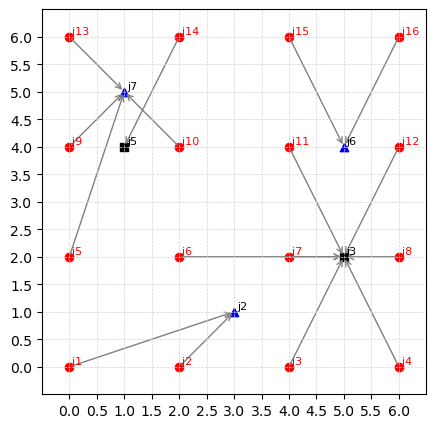

In [249]:
fig, ax = plt.subplots(figsize=(5,5))

# Plot the grid and demand points
demand_points_gdf.plot(ax=ax, color='red', label='Demand points')

# Add labels for demand points
for idx, row in demand_points_gdf.iterrows():
    ax.text(row.geometry.x + 0.05, row.geometry.y + 0.05, row['label'], fontsize=8, color='red')


# Plot open HPs and HCs separately
hps_open_gdf = open_hfs_gdf[open_hfs_gdf['facility_type'] == 'hp']
hcs_open_gdf = open_hfs_gdf[open_hfs_gdf['facility_type'] == 'hc']

hps_open_gdf.plot(ax=ax, color='blue', marker='^', label='HPs')
hcs_open_gdf.plot(ax=ax, color='black', marker='s',label='HCs')

# Add labels for open facilities
for idx, row in open_hfs_gdf.iterrows():
    ax.text(row.geometry.x + 0.05, row.geometry.y + 0.05, row['label'], fontsize=8, color='black')


# To display the first assignment in the plot
for (start, end) in connections1:
    ax.annotate(
        '', xy=(end.x, end.y), xytext=(start.x, start.y),
        arrowprops=dict(arrowstyle='->', color='gray', lw=1),
        zorder=1
    )


"""
# To display the second assignment in the plot

for (start, end) in connections2:
    ax.annotate(
        '', xy=(end.x, end.y), xytext=(start.x, start.y),
        arrowprops=dict(arrowstyle='->', color='orange', lw=1),
        zorder=1
    )
"""
# Set axis limits based on your grid dimensions (6x6)
ax.set_xlim(-0.5, 6.5)
ax.set_ylim(-0.5, 6.5)

# Add gridlines at every 0.5 unit
ax.set_xticks([x * 0.5 for x in range(13)])  # From 0 to 6 with a step of 0.5
ax.set_yticks([y * 0.5 for y in range(13)])
ax.grid(color='lightgray', linestyle='--', linewidth=0.5)

# Add legend and show plot
#ax.legend()
#plt.title("Location-Allocation Solution with Grid")

plt.show()